# Imports

In [1]:
#!pip3 install arch
#!pip3 install statsmodels
#!pip3 install sklearn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from arch import arch_model

from scipy import stats

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Load Data

In [3]:
data=pd.read_csv('household_power_consumption.txt',delimiter=';')

# 0. Isolate Time Series and Preprocess Data

## 0.1 Preprocess Data

In [4]:
data.loc[:,'Global_active_power'] =  data.loc[:,'Global_active_power'].astype(str).str.replace('?','0')

In [5]:
data.iloc[:,2] = data.iloc[:,2].astype(float)
data = data.groupby('Date').mean()
data.index = pd.to_datetime(data.index)
data = data.resample('1W').mean().ffill()
data = data['Global_active_power']

In [6]:
data

Date
2006-12-17    2.703980
2006-12-24    1.733842
2006-12-31    1.957988
2007-01-07    1.152056
2007-01-14    1.419497
                ...   
2010-11-14    1.095262
2010-11-21    1.107106
2010-11-28    1.186546
2010-12-05    1.152195
2010-12-12    1.000114
Freq: W-SUN, Name: Global_active_power, Length: 209, dtype: float64

In [7]:
data = data.iloc[1:]

In [8]:
data = data.dropna()

<AxesSubplot:xlabel='Date'>

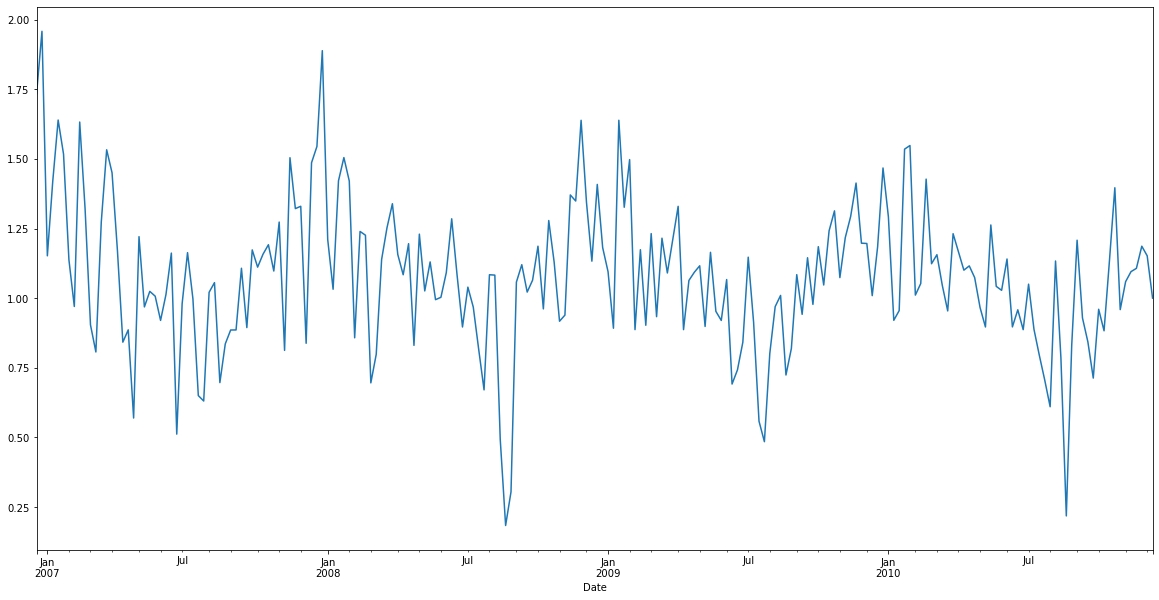

In [9]:
data.plot()

## 0.2 Saving Data

In [10]:
# Saving the data :
data.to_csv('time_series.csv')

### This time series represents the average Global_active_power in a household between 2007 and 2010. 
### The frequency of the data is weekly.
### The aim of this analysis is to predict the weekly avrage Global_active_power in this household using econometric models.

# 1. Stationarity

## 1.1 Rolling Statistics of the Raw time series: 
Plot the rolling mean and rolling standard deviation. The time series is stationary if they remain constant with time (with the naked eye look to see if the lines are straight and parallel to the x-axis).

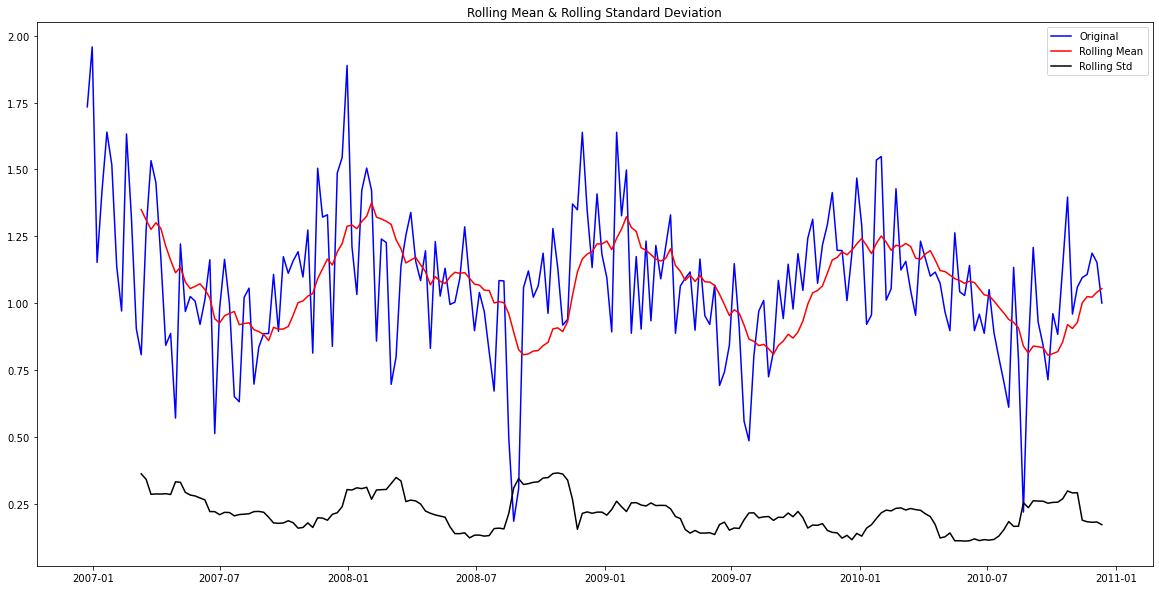

In [11]:
rolling_mean = data.rolling(window = 12).mean()
rolling_std = data.rolling(window = 12).std()
plt.plot(data, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

As we can see, the rolling mean and rolling standard deviation don't highly vary with time.

## 1.2 Train test split
We split the data for train and test:
* Before 2010 :  train
* 2010 : test

In [12]:
data_train = data[data.index<'2010']
data_test = data[data.index>='2010']

## 1.3 Detrending  (over the train period)

From the previous plot, we can see that the time series have some seasonality and light trend.
To obtain a stationary process, we use the following :
1) We fit a linear regression as a trend

2) We use seasonal_decompose to find seasonality

3) The resulting process "residual_1" should be stationary and we will use it the fit the models

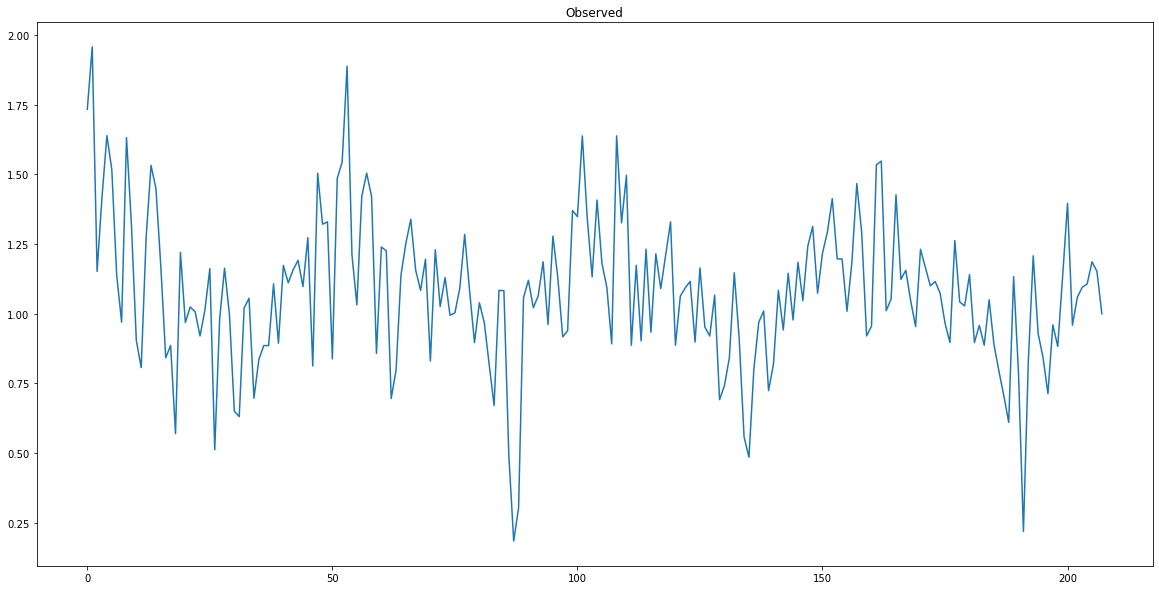

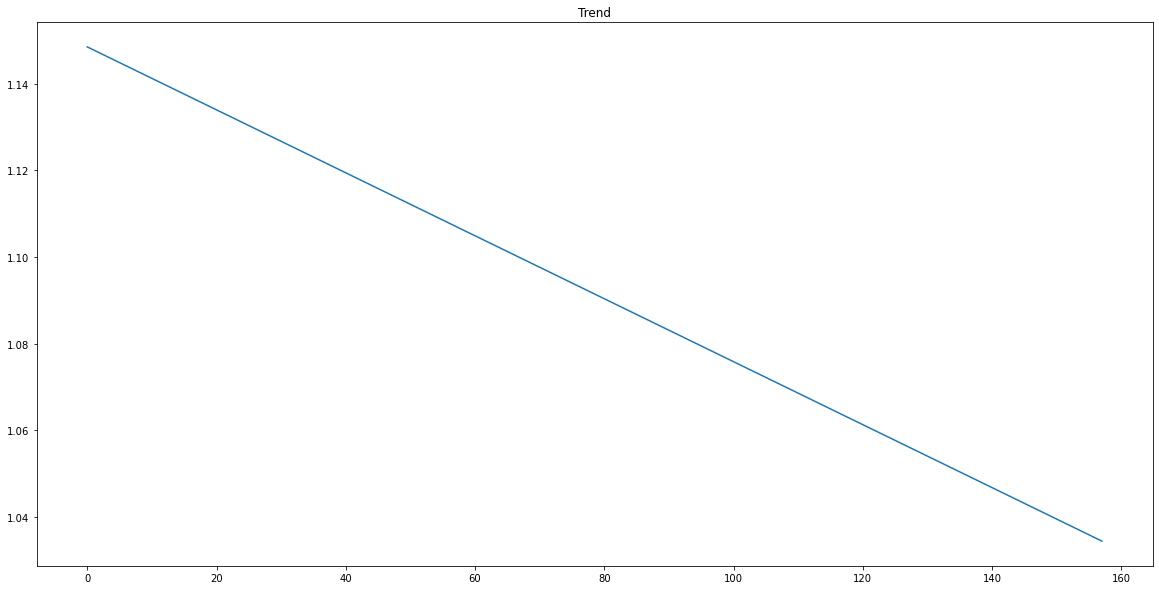

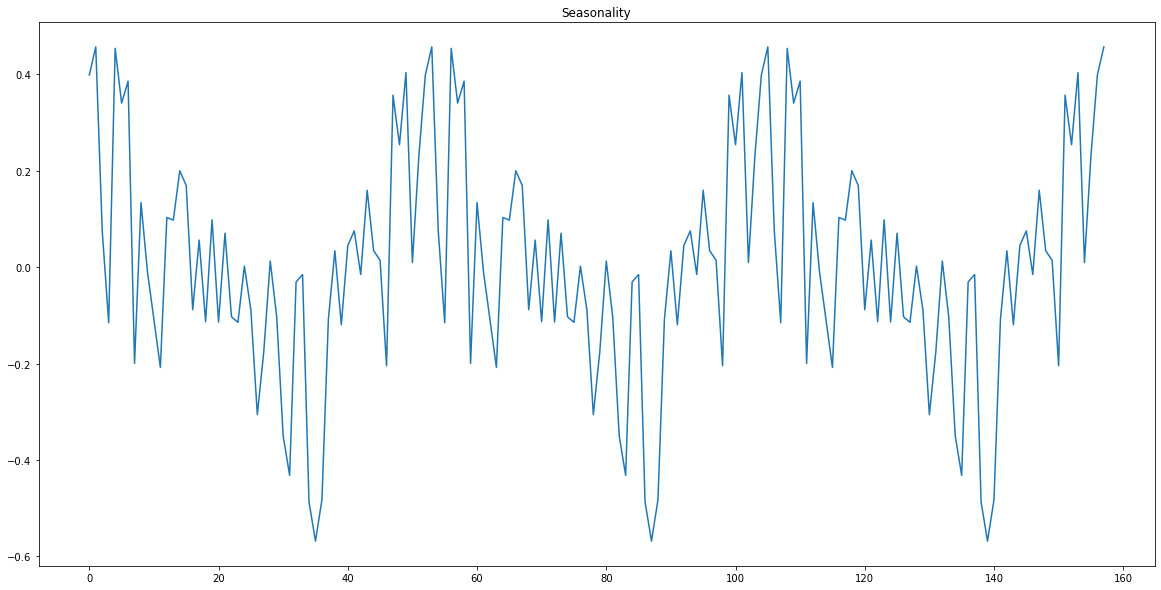

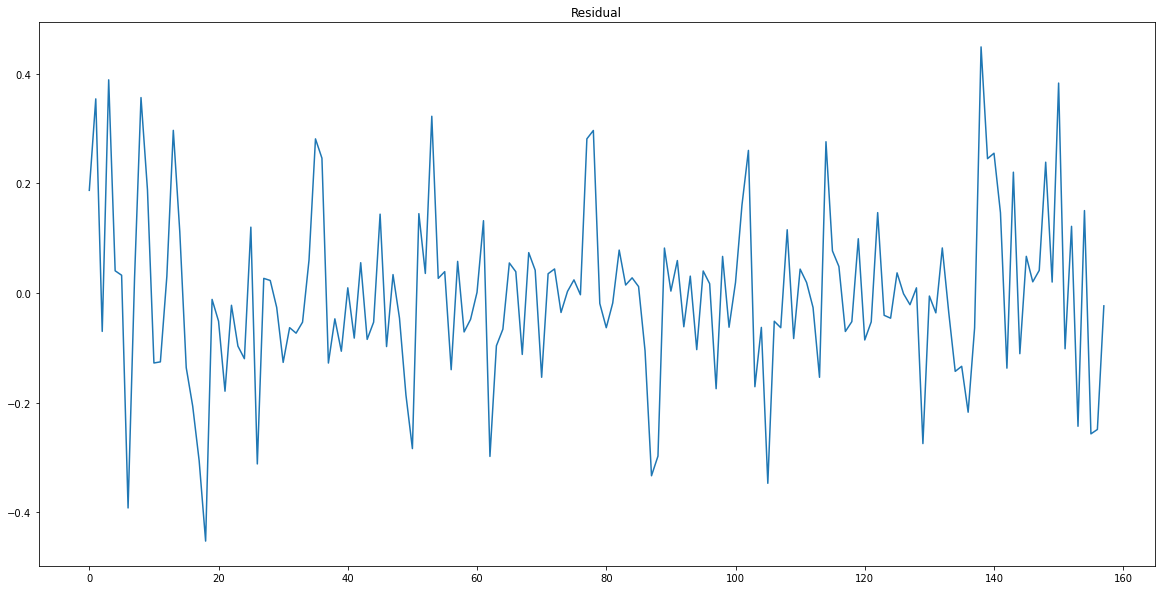

In [13]:
X = np.linspace(1,len(data_train),num = len(data_train)).reshape(-1,1) #time steps

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),LinearRegression(**kwargs))

y_test = PolynomialRegression(degree=1).fit(X, data_train).predict(X)

detrend1 = seasonal_decompose(data_train, freq=52)
trend_1 = y_test
seasonality_1 = detrend1.seasonal
residual_1 = data_train - seasonality_1 - trend_1
#residual_1 = detrend1.resid
trend_1 = pd.DataFrame(trend_1)
trend_1.size

labels = ["Observed", "Trend", "Seasonality", "Residual"]
for i, j in enumerate( [ data, trend_1, seasonality_1, residual_1 ] ):
    plt.plot(j.values)
    plt.title(labels[i])
    plt.show()

## 1.4 ADF on the detrended time series

In [14]:
result = adfuller(residual_1)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -7.7499530898013145
p-value: 1.0082158817105111e-11
Critical Values:
	1%: -3.4732590518613002
	5%: -2.880374082105334
	10%: -2.5768120811654525


As expected, the p-value is lower than the 1% threshold, we can conclude that the residual time series is stationary.

# 2. ARMA

The ARMA model is simply the combination of the AR and MA models.
* Autoregressive (AR) models operate under the premise that past values have an effect on current values. AR models are commonly used in analyzing nature, economics, and other time-varying processes. As long as the assumption holds, we can build a linear regression model that attempts to predict value of a dependent variable this week, given the values it had on previous weeks.
* Moving Average Model (MA) assumes the value of the dependent variable on the current day depends on the previous days error terms.

## 2.1 ACF
The correlation between the observations at the current point in time and the observations at all previous points in time. We can use ACF to determine the optimal number of MA terms. The number of terms determines the order of the model.

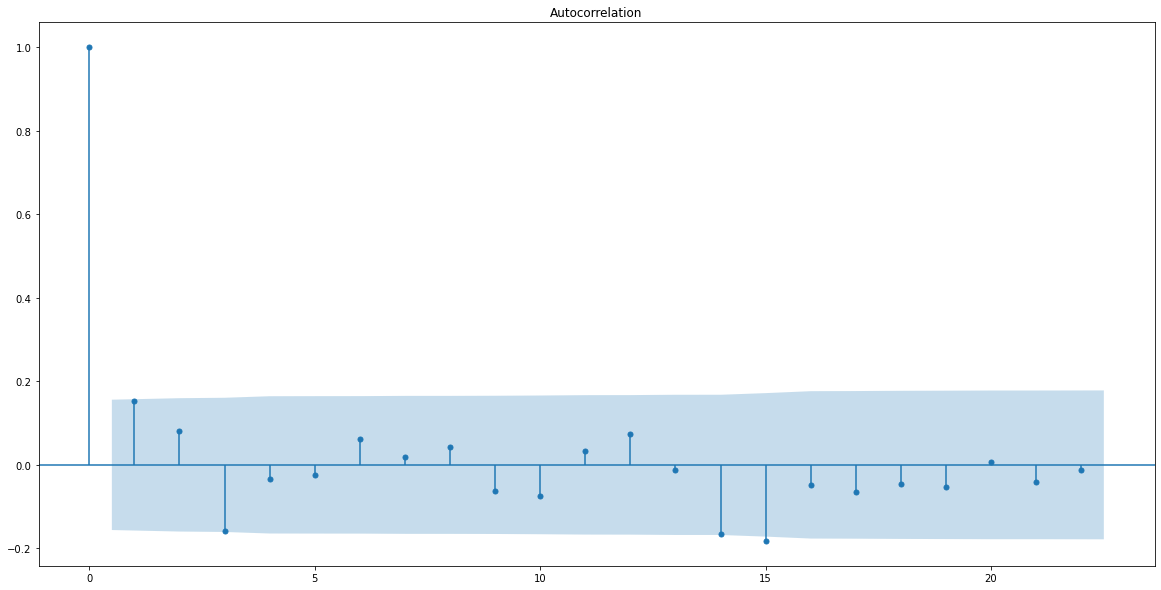

In [15]:
plot_acf(residual_1)
plt.show()

## 2.2 PACF
As the name implies, PACF is a subset of ACF. PACF expresses the correlation between observations made at two points in time while accounting for any influence from other data points. We can use PACF to determine the optimal number of terms to use in the AR model. The number of terms determines the order of the model.

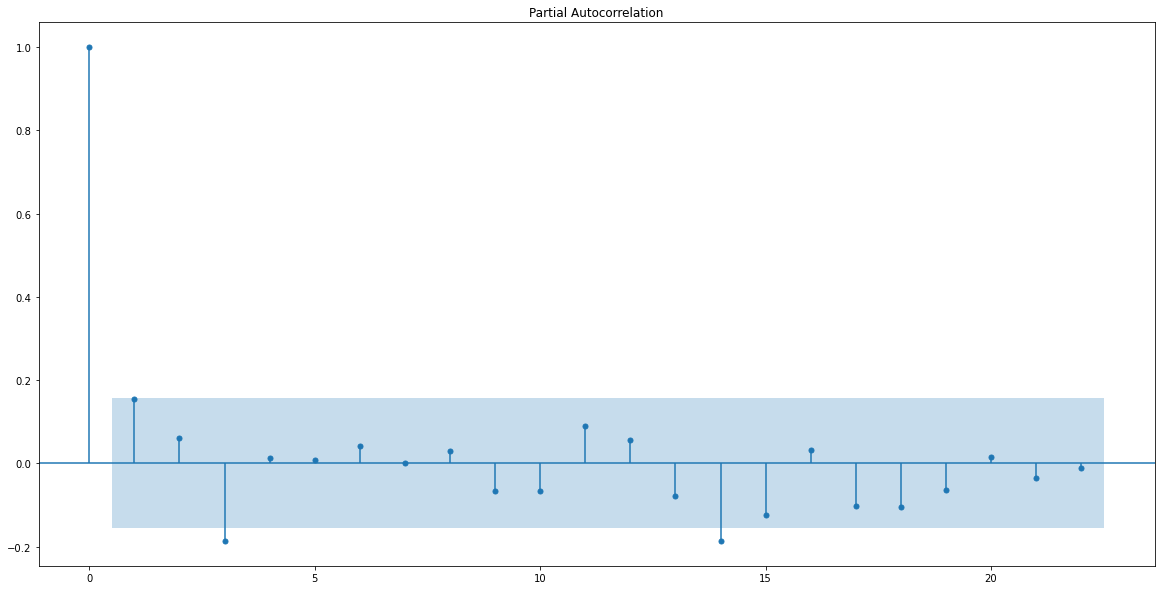

In [16]:
plot_pacf(residual_1)
plt.show()

In next part we are going fit previous models up to p=4 and q=4 (from the ACF and PACF) and sort according to RMSE and BIC metrics.

## 2.3 Fitting ARMA (over the train period)

In [17]:
Model_results = {}
in_sample_preds = []
columns = []
for p in [1,2,3,4]:
    for q in [1,2,3,4]:
        try:
            model = ARIMA(residual_1, order=(p,0,q))
            globals()["results_{}{}".format(p,q)] = model.fit()
            results = globals()["results_{}{}".format(p,q)]
            print("ARMA({},{})".format(p,q))
            display(results.summary())
            Model_results["({},{})".format(p,q)] = (results.bic,mean_squared_error(residual_1.values, results.fittedvalues)**0.5)
            in_sample_preds.append(results.fittedvalues)
            columns.append("ARMA({},{})".format(p,q))
        except:
            print("ARMA({},{}) model cannot be fitted.".format(p,q))
            print("\n")
df_summary = pd.DataFrame(Model_results).T
df_summary.columns = ["BIC", "RMSE_train"]
df_summary.columns.name = "ARMA(p,q)"

ARMA(1,1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  158
Model:                     ARMA(1, 1)   Log Likelihood                  69.456
Method:                       css-mle   S.D. of innovations              0.156
Date:                Thu, 20 May 2021   AIC                           -130.912
Time:                        14:02:39   BIC                           -118.661
Sample:                    12-24-2006   HQIC                          -125.937
                         - 12-27-2009                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0052      0.015     -0.344      0.731      -0.035       0.024
ar.L1.y        0.2746      0.280      0.979      0.327      -0.275       0.824
ma.L1.y       -0.1210      0.281     -0.431      0.667      -0.672       0.429
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.6421           +0.0000j            3.6421            0.0000
MA.1            8.2616           +0.0000j            8.2616            0.0000
-----------------------------------------------------------------------------
"""

ARMA(1,2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  158
Model:                     ARMA(1, 2)   Log Likelihood                  71.737
Method:                       css-mle   S.D. of innovations              0.154
Date:                Thu, 20 May 2021   AIC                           -133.475
Time:                        14:02:39   BIC                           -118.162
Sample:                    12-24-2006   HQIC                          -127.256
                         - 12-27-2009                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0047      0.015     -0.304      0.761      -0.035       0.025
ar.L1.y       -0.6087      0.430     -1.416      0.157      -1.451       0.234
ma.L1.y        0.7795      0.419      1.860      0.063      -0.042       1.601
ma.L2.y        0.2424      0.078      3.101      0.002       0.089       0.396
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6428           +0.0000j            1.6428            0.5000
MA.1           -1.6081           -1.2410j            2.0313           -0.3954
MA.2           -1.6081           +1.2410j            2.0313            0.3954
-----------------------------------------------------------------------------
"""

ARMA(1,3)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  158
Model:                     ARMA(1, 3)   Log Likelihood                  73.104
Method:                       css-mle   S.D. of innovations              0.151
Date:                Thu, 20 May 2021   AIC                           -134.208
Time:                        14:02:39   BIC                           -115.832
Sample:                    12-24-2006   HQIC                          -126.745
                         - 12-27-2009                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0091      0.003     -2.608      0.009      -0.016      -0.002
ar.L1.y        0.9078      0.042     21.540      0.000       0.825       0.990
ma.L1.y       -0.7625      0.092     -8.285      0.000      -0.943      -0.582
ma.L2.y       -0.0300      0.092     -0.326      0.744      -0.210       0.150
ma.L3.y       -0.2075      0.090     -2.298      0.022      -0.384      -0.030
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1015           +0.0000j            1.1015            0.0000
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.5724           -2.1195j            2.1955           -0.2920
MA.3           -0.5724           +2.1195j            2.1955            0.2920
-----------------------------------------------------------------------------
"""

ARMA(1,4)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  158
Model:                     ARMA(1, 4)   Log Likelihood                  73.829
Method:                       css-mle   S.D. of innovations              0.151
Date:                Thu, 20 May 2021   AIC                           -133.657
Time:                        14:02:40   BIC                           -112.219
Sample:                    12-24-2006   HQIC                          -124.951
                         - 12-27-2009                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0086      0.004     -2.198      0.028      -0.016      -0.001
ar.L1.y        0.9322      0.041     22.969      0.000       0.853       1.012
ma.L1.y       -0.8036      0.091     -8.822      0.000      -0.982      -0.625
ma.L2.y       -0.0335      0.103     -0.326      0.744      -0.235       0.168
ma.L3.y       -0.2673      0.102     -2.625      0.009      -0.467      -0.068
ma.L4.y        0.1044      0.085      1.228      0.219      -0.062       0.271
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0728           +0.0000j            1.0728            0.0000
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.7873           -1.5605j            1.7478           -0.3244
MA.3           -0.7873           +1.5605j            1.7478            0.3244
MA.4            3.1340           -0.0000j            3.1340           -0.0000
-----------------------------------------------------------------------------
"""

ARMA(2,1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  158
Model:                     ARMA(2, 1)   Log Likelihood                  71.274
Method:                       css-mle   S.D. of innovations              0.154
Date:                Thu, 20 May 2021   AIC                           -132.548
Time:                        14:02:40   BIC                           -117.235
Sample:                    12-24-2006   HQIC                          -126.329
                         - 12-27-2009                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0046      0.016     -0.296      0.767      -0.035       0.026
ar.L1.y       -0.5815      0.265     -2.198      0.028      -1.100      -0.063
ar.L2.y        0.2231      0.080      2.789      0.005       0.066       0.380
ma.L1.y        0.7393      0.265      2.785      0.005       0.219       1.260
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1828           +0.0000j            1.1828            0.5000
AR.2            3.7886           +0.0000j            3.7886            0.0000
MA.1           -1.3526           +0.0000j            1.3526            0.5000
-----------------------------------------------------------------------------
"""

ARMA(2,2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  158
Model:                     ARMA(2, 2)   Log Likelihood                  72.200
Method:                       css-mle   S.D. of innovations              0.153
Date:                Thu, 20 May 2021   AIC                           -132.399
Time:                        14:02:40   BIC                           -114.024
Sample:                    12-24-2006   HQIC                          -124.937
                         - 12-27-2009                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0049      0.014     -0.348      0.727      -0.032       0.023
ar.L1.y       -0.1710      0.167     -1.027      0.305      -0.497       0.155
ar.L2.y       -0.6700      0.186     -3.593      0.000      -1.035      -0.304
ma.L1.y        0.3263      0.142      2.301      0.021       0.048       0.604
ma.L2.y        0.7993      0.143      5.570      0.000       0.518       1.080
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.1276           -1.2150j            1.2217           -0.2667
AR.2           -0.1276           +1.2150j            1.2217            0.2667
MA.1           -0.2041           -1.0998j            1.1186           -0.2792
MA.2           -0.2041           +1.0998j            1.1186            0.2792
-----------------------------------------------------------------------------
"""

ARMA(2,3)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  158
Model:                     ARMA(2, 3)   Log Likelihood                  72.363
Method:                       css-mle   S.D. of innovations              0.153
Date:                Thu, 20 May 2021   AIC                           -130.727
Time:                        14:02:41   BIC                           -109.288
Sample:                    12-24-2006   HQIC                          -122.020
                         - 12-27-2009                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0050      0.013     -0.380      0.704      -0.031       0.021
ar.L1.y        0.2328      0.486      0.479      0.632      -0.719       1.185
ar.L2.y       -0.0489      0.448     -0.109      0.913      -0.928       0.830
ma.L1.y       -0.0728      0.481     -0.151      0.880      -1.016       0.870
ma.L2.y        0.1280      0.472      0.271      0.786      -0.797       1.053
ma.L3.y       -0.1735      0.127     -1.364      0.173      -0.423       0.076
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3802           -3.8446j            4.5218           -0.1618
AR.2            2.3802           +3.8446j            4.5218            0.1618
MA.1           -0.6244           -1.5846j            1.7032           -0.3097
MA.2           -0.6244           +1.5846j            1.7032            0.3097
MA.3            1.9869           -0.0000j            1.9869           -0.0000
-----------------------------------------------------------------------------
"""

ARMA(2,4)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  158
Model:                     ARMA(2, 4)   Log Likelihood                  72.926
Method:                       css-mle   S.D. of innovations              0.152
Date:                Thu, 20 May 2021   AIC                           -129.851
Time:                        14:02:41   BIC                           -105.351
Sample:                    12-24-2006   HQIC                          -119.901
                         - 12-27-2009                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0049      0.013     -0.378      0.705      -0.030       0.021
ar.L1.y       -0.6306      0.480     -1.313      0.189      -1.572       0.311
ar.L2.y        0.3450      0.471      0.732      0.464      -0.579       1.269
ma.L1.y        0.7992      0.474      1.684      0.092      -0.131       1.729
ma.L2.y       -0.1263      0.549     -0.230      0.818      -1.203       0.951
ma.L3.y       -0.1387      0.162     -0.857      0.391      -0.456       0.178
ma.L4.y       -0.1573      0.088     -1.781      0.075      -0.330       0.016
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0184           +0.0000j            1.0184            0.5000
AR.2            2.8463           +0.0000j            2.8463            0.0000
MA.1           -1.0433           -0.0000j            1.0433           -0.5000
MA.2            1.6996           -0.0000j            1.6996           -0.0000
MA.3           -0.7693           -1.7304j            1.8937           -0.3166
MA.4           -0.7693           +1.7304j            1.8937            0.3166
-----------------------------------------------------------------------------
"""

ARMA(3,1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  158
Model:                     ARMA(3, 1)   Log Likelihood                  72.536
Method:                       css-mle   S.D. of innovations              0.153
Date:                Thu, 20 May 2021   AIC                           -133.072
Time:                        14:02:41   BIC                           -114.697
Sample:                    12-24-2006   HQIC                          -125.610
                         - 12-27-2009                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0049      0.013     -0.376      0.707      -0.031       0.021
ar.L1.y        0.0538      0.434      0.124      0.901      -0.797       0.904
ar.L2.y        0.1042      0.101      1.030      0.303      -0.094       0.302
ar.L3.y       -0.1861      0.087     -2.133      0.033      -0.357      -0.015
ma.L1.y        0.1084      0.444      0.244      0.807      -0.761       0.978
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6328           -0.0000j            1.6328           -0.5000
AR.2            1.0964           -1.4454j            1.8142           -0.1467
AR.3            1.0964           +1.4454j            1.8142            0.1467
MA.1           -9.2282           +0.0000j            9.2282            0.5000
-----------------------------------------------------------------------------
"""

ARMA(3,2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  158
Model:                     ARMA(3, 2)   Log Likelihood                  73.431
Method:                       css-mle   S.D. of innovations              0.151
Date:                Thu, 20 May 2021   AIC                           -132.862
Time:                        14:02:42   BIC                           -111.423
Sample:                    12-24-2006   HQIC                          -124.155
                         - 12-27-2009                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0089      0.004     -2.446      0.014      -0.016      -0.002
ar.L1.y        0.4446      0.260      1.712      0.087      -0.064       0.954
ar.L2.y        0.7053      0.256      2.754      0.006       0.203       1.207
ar.L3.y       -0.2516      0.080     -3.139      0.002      -0.409      -0.094
ma.L1.y       -0.3207      0.264     -1.215      0.224      -0.838       0.196
ma.L2.y       -0.6793      0.263     -2.579      0.010      -1.196      -0.163
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2348           +0.0000j            1.2348            0.5000
AR.2            1.0930           +0.0000j            1.0930            0.0000
AR.3            2.9455           +0.0000j            2.9455            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.4721           +0.0000j            1.4721            0.5000
-----------------------------------------------------------------------------
"""

ARMA(3,3)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  158
Model:                     ARMA(3, 3)   Log Likelihood                  73.796
Method:                       css-mle   S.D. of innovations              0.151
Date:                Thu, 20 May 2021   AIC                           -131.593
Time:                        14:02:43   BIC                           -107.092
Sample:                    12-24-2006   HQIC                          -121.643
                         - 12-27-2009                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0087      0.004     -2.244      0.025      -0.016      -0.001
ar.L1.y        0.6660      0.380      1.754      0.079      -0.078       1.410
ar.L2.y       -0.0129      0.781     -0.017      0.987      -1.543       1.517
ar.L3.y        0.2401      0.500      0.480      0.631      -0.739       1.219
ma.L1.y       -0.5354      0.367     -1.460      0.144      -1.254       0.184
ma.L2.y        0.0123      0.708      0.017      0.986      -1.376       1.400
ma.L3.y       -0.4769      0.432     -1.103      0.270      -1.324       0.370
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0755           -0.0000j            1.0755           -0.0000
AR.2           -0.5108           -1.9006j            1.9680           -0.2918
AR.3           -0.5108           +1.9006j            1.9680            0.2918
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.4871           -1.3637j            1.4481           -0.3046
MA.3           -0.4871           +1.3637j            1.4481            0.3046
-----------------------------------------------------------------------------
"""

ARMA(3,4)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  158
Model:                     ARMA(3, 4)   Log Likelihood                  74.213
Method:                       css-mle   S.D. of innovations              0.150
Date:                Thu, 20 May 2021   AIC                           -130.426
Time:                        14:02:44   BIC                           -102.863
Sample:                    12-24-2006   HQIC                          -119.233
                         - 12-27-2009                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0088      0.004     -2.356      0.018      -0.016      -0.001
ar.L1.y       -0.3259      0.387     -0.842      0.400      -1.084       0.432
ar.L2.y        0.8884      0.052     17.002      0.000       0.786       0.991
ar.L3.y        0.2400      0.362      0.663      0.507      -0.469       0.949
ma.L1.y        0.4678      0.378      1.238      0.216      -0.273       1.208
ma.L2.y       -0.7530      0.101     -7.486      0.000      -0.950      -0.556
ma.L3.y       -0.4975      0.359     -1.386      0.166      -1.201       0.206
ma.L4.y       -0.2172      0.104     -2.083      0.037      -0.422      -0.013
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0855           +0.0000j            1.0855            0.0000
AR.2           -1.0185           +0.0000j            1.0185            0.5000
AR.3           -3.7684           +0.0000j            3.7684            0.5000
MA.1            1.0001           -0.0000j            1.0001           -0.0000
MA.2           -1.0432           -0.0000j            1.0432           -0.5000
MA.3           -1.1238           -1.7751j            2.1009           -0.3398
MA.4           -1.1238           +1.7751j            2.1009            0.3398
-----------------------------------------------------------------------------
"""

ARMA(4,1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  158
Model:                     ARMA(4, 1)   Log Likelihood                  72.561
Method:                       css-mle   S.D. of innovations              0.153
Date:                Thu, 20 May 2021   AIC                           -131.122
Time:                        14:02:44   BIC                           -109.684
Sample:                    12-24-2006   HQIC                          -122.415
                         - 12-27-2009                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0048      0.014     -0.356      0.722      -0.031       0.022
ar.L1.y        0.7126      0.981      0.727      0.467      -1.209       2.635
ar.L2.y        0.0003      0.181      0.002      0.999      -0.355       0.355
ar.L3.y       -0.2446      0.128     -1.908      0.056      -0.496       0.007
ar.L4.y        0.1289      0.189      0.681      0.496      -0.242       0.500
ma.L1.y       -0.5504      0.982     -0.561      0.575      -2.475       1.374
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6825           -0.0000j            1.6825           -0.5000
AR.2            0.9816           -1.3740j            1.6886           -0.1513
AR.3            0.9816           +1.3740j            1.6886            0.1513
AR.4            1.6168           -0.0000j            1.6168           -0.0000
MA.1            1.8168           +0.0000j            1.8168            0.0000
-----------------------------------------------------------------------------
"""

ARMA(4,2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  158
Model:                     ARMA(4, 2)   Log Likelihood                  72.787
Method:                       css-mle   S.D. of innovations              0.151
Date:                Thu, 20 May 2021   AIC                           -129.573
Time:                        14:02:44   BIC                           -105.072
Sample:                    12-24-2006   HQIC                          -119.623
                         - 12-27-2009                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0053      0.014     -0.373      0.709      -0.033       0.023
ar.L1.y        0.7160      0.084      8.555      0.000       0.552       0.880
ar.L2.y       -0.9457      0.099     -9.512      0.000      -1.141      -0.751
ar.L3.y        0.0428      0.104      0.413      0.680      -0.160       0.246
ar.L4.y        0.0043      0.091      0.047      0.963      -0.174       0.182
ma.L1.y       -0.5975      0.018    -34.016      0.000      -0.632      -0.563
ma.L2.y        1.0000        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.3631           -0.9791j            1.0443           -0.1935
AR.2            0.3631           +0.9791j            1.0443            0.1935
AR.3           10.2452           -0.0000j           10.2452           -0.0000
AR.4          -21.0374           -0.0000j           21.0374           -0.5000
MA.1            0.2988           -0.9543j            1.0000           -0.2017
MA.2            0.2988           +0.9543j            1.0000            0.2017
-----------------------------------------------------------------------------
"""

ARMA(4,3)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  158
Model:                     ARMA(4, 3)   Log Likelihood                  73.886
Method:                       css-mle   S.D. of innovations              0.149
Date:                Thu, 20 May 2021   AIC                           -129.771
Time:                        14:02:45   BIC                           -102.208
Sample:                    12-24-2006   HQIC                          -118.577
                         - 12-27-2009                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0049      0.015     -0.339      0.734      -0.033       0.024
ar.L1.y       -0.2174      0.096     -2.275      0.023      -0.405      -0.030
ar.L2.y       -0.2447      0.055     -4.455      0.000      -0.352      -0.137
ar.L3.y       -0.8742      0.059    -14.870      0.000      -0.989      -0.759
ar.L4.y        0.0988      0.091      1.081      0.280      -0.080       0.278
ma.L1.y        0.3544      0.049      7.200      0.000       0.258       0.451
ma.L2.y        0.4334        nan        nan        nan         nan         nan
ma.L3.y        0.9505        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0193           -0.0000j            1.0193           -0.5000
AR.2            0.3547           -0.9790j            1.0412           -0.1947
AR.3            0.3547           +0.9790j            1.0412            0.1947
AR.4            9.1549           -0.0000j            9.1549           -0.0000
MA.1            0.2981           -0.9545j            1.0000           -0.2018
MA.2            0.2981           +0.9545j            1.0000            0.2018
MA.3           -1.0521           -0.0000j            1.0521           -0.5000
-----------------------------------------------------------------------------
"""

ARMA(4,4)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  158
Model:                     ARMA(4, 4)   Log Likelihood                  74.705
Method:                       css-mle   S.D. of innovations              0.149
Date:                Thu, 20 May 2021   AIC                           -129.410
Time:                        14:02:46   BIC                            -98.784
Sample:                    12-24-2006   HQIC                          -116.973
                         - 12-27-2009                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0051      0.014     -0.356      0.722      -0.033       0.023
ar.L1.y       -0.2857      0.596     -0.479      0.632      -1.455       0.883
ar.L2.y       -0.4506      0.230     -1.957      0.050      -0.902       0.001
ar.L3.y       -0.7699      0.299     -2.571      0.010      -1.357      -0.183
ar.L4.y       -0.2316      0.459     -0.505      0.614      -1.131       0.667
ma.L1.y        0.4226      0.575      0.735      0.462      -0.704       1.550
ma.L2.y        0.6558      0.231      2.842      0.004       0.204       1.108
ma.L3.y        0.8369      0.356      2.352      0.019       0.139       1.534
ma.L4.y        0.3747      0.444      0.844      0.399      -0.495       1.245
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.3869           -0.9572j            1.0324           -0.1889
AR.2            0.3869           +0.9572j            1.0324            0.1889
AR.3           -1.6646           -0.0000j            1.6646           -0.5000
AR.4           -2.4331           -0.0000j            2.4331           -0.5000
MA.1            0.3313           -0.9435j            1.0000           -0.1963
MA.2            0.3313           +0.9435j            1.0000            0.1963
MA.3           -1.4479           -0.7564j            1.6336           -0.4234
MA.4           -1.4479           +0.7564j            1.6336            0.4234
-----------------------------------------------------------------------------
"""

In [18]:
df_summary.sort_values(by="BIC").iloc[0]

ARMA(p,q)
BIC          -118.661424
RMSE_train      0.155908
Name: (1,1), dtype: float64

The best model according to BIC is : ARMA(1,1)

In [19]:
df_summary.sort_values(by="RMSE_train").iloc[0]

ARMA(p,q)
BIC          -98.784485
RMSE_train     0.151381
Name: (4,4), dtype: float64

The best model according to RMSE is : ARMA(4,4)

The following plots represent :

1) the fitted process (residual) using ARMA(1,1) and the real residual process

1) the fitted process (residual) using ARMA(4,4) and the real residual process

Text(0.5, 1.0, 'ARMA(1,1)')

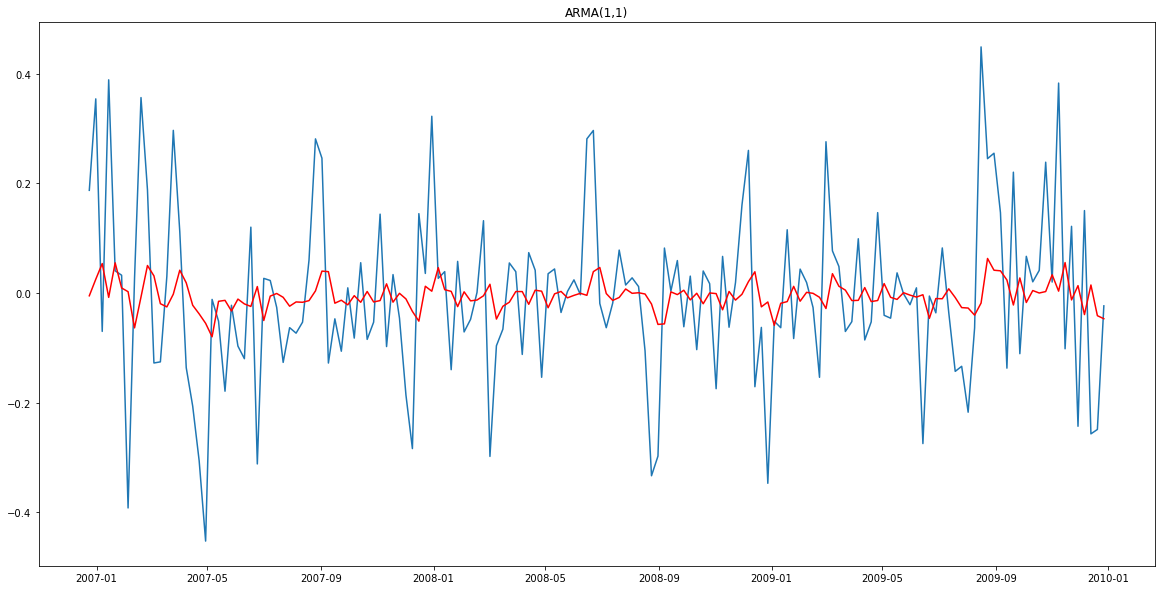

In [20]:
model = ARIMA(residual_1, order=(1,0,1))
results = model.fit(disp=-1)
plt.plot(residual_1)
plt.plot(results.fittedvalues, color='red')
plt.title('ARMA(1,1)')

Text(0.5, 1.0, 'ARMA(4,4)')

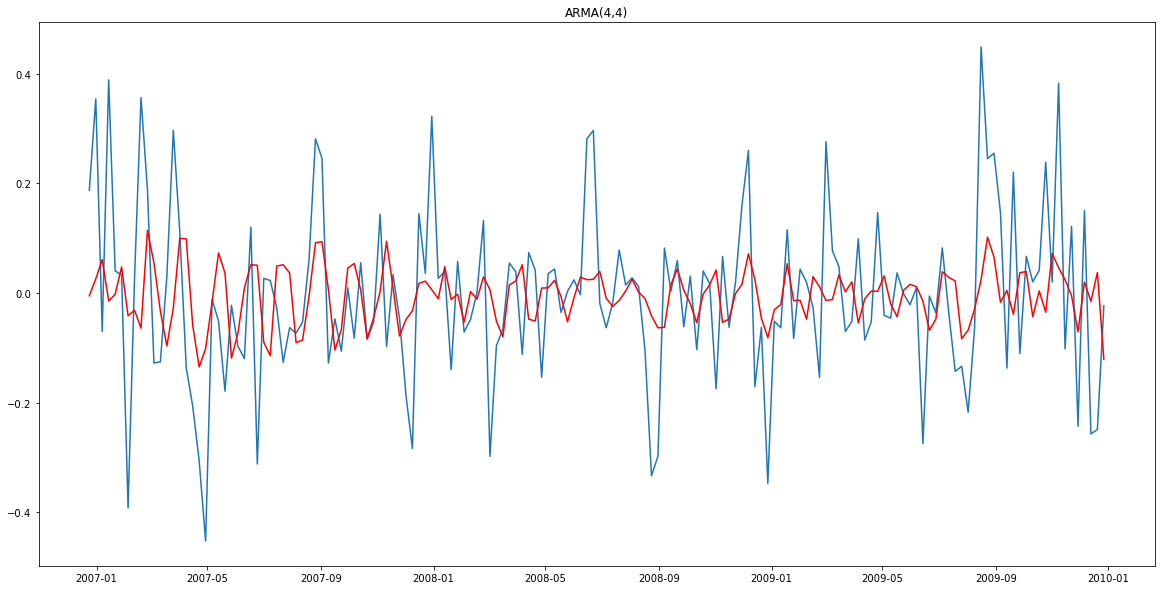

In [21]:
model = ARIMA(residual_1, order=(4,0,4))
results = model.fit(disp=-1)
plt.plot(residual_1)
plt.plot(results.fittedvalues, color='red')
plt.title('ARMA(4,4)')

Graphically, ARMA(4,4) catches better the variance of time series.

## 3. Residual Analysis (ARMA(4,4) is selected)

To verify the goodness of our model, we conduct a residual analysis :

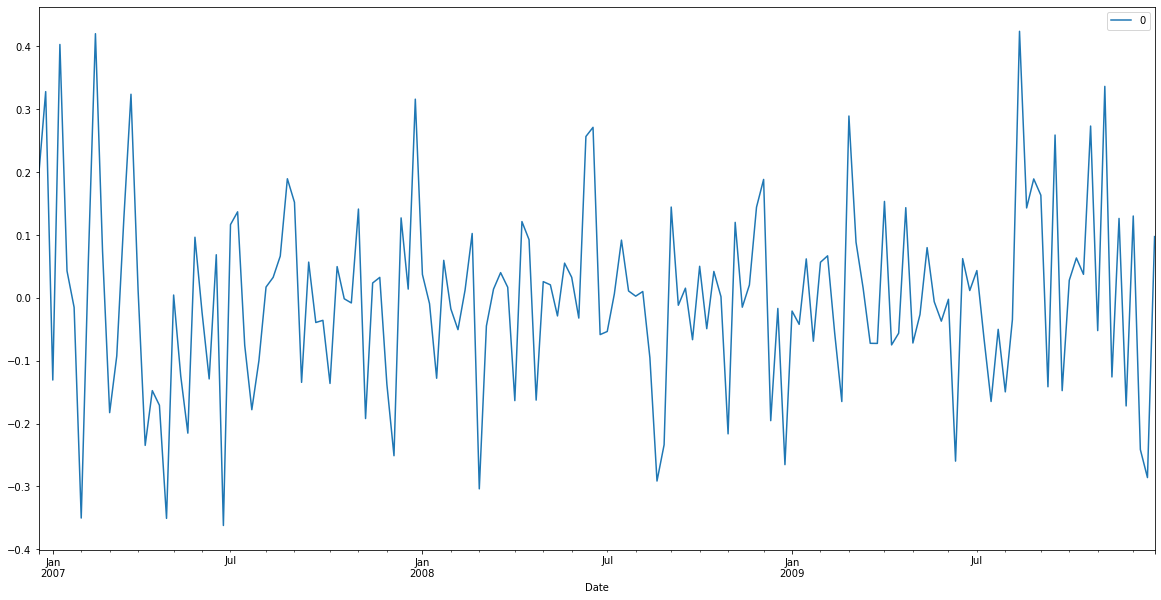

In [22]:
residuals = pd.DataFrame(results.resid)
residuals.plot()
plt.show()

#### The resisuals look centered around zero and homoscedastic.

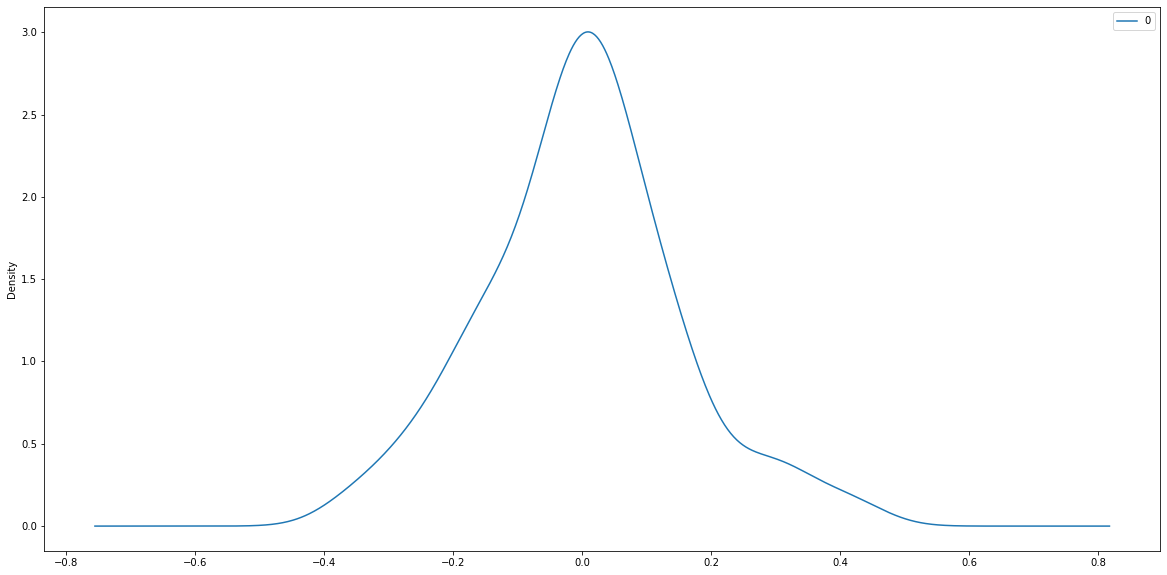

                0
count  158.000000
mean    -0.000092
std      0.151863
min     -0.362224
25%     -0.075303
50%      0.005386
75%      0.072737
max      0.424129
NormaltestResult(statistic=array([2.98197157]), pvalue=array([0.2251506]))


In [23]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())
# normality test of residuals
print(stats.normaltest(residuals))

#### The graph looks like a normal distribution and the normality test confirms it.

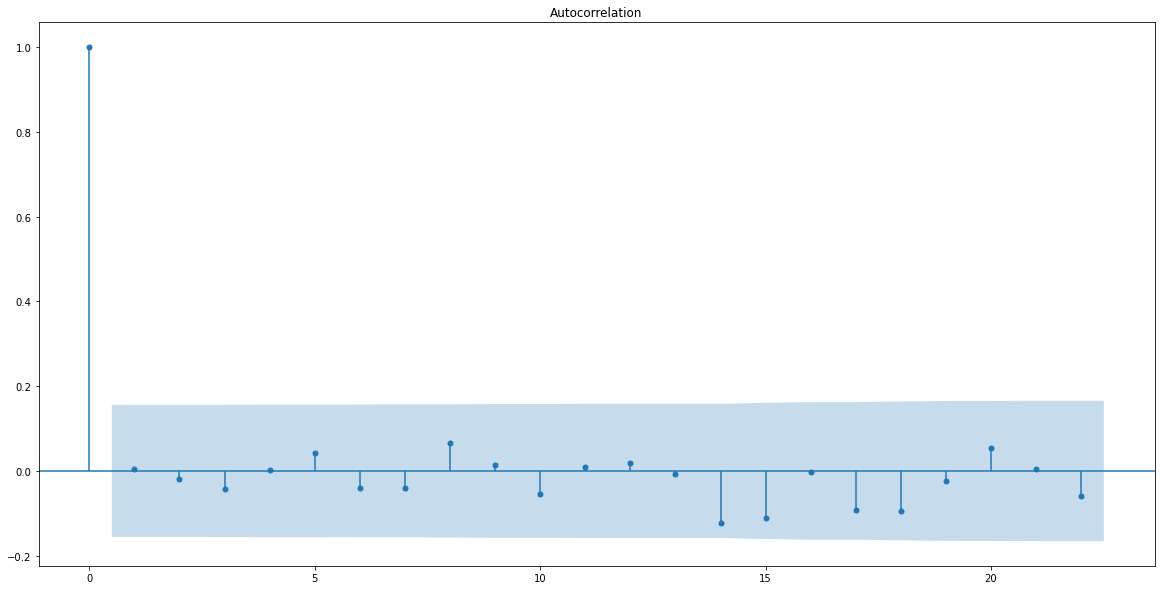

In [24]:
plot_acf(residuals)
plt.show()

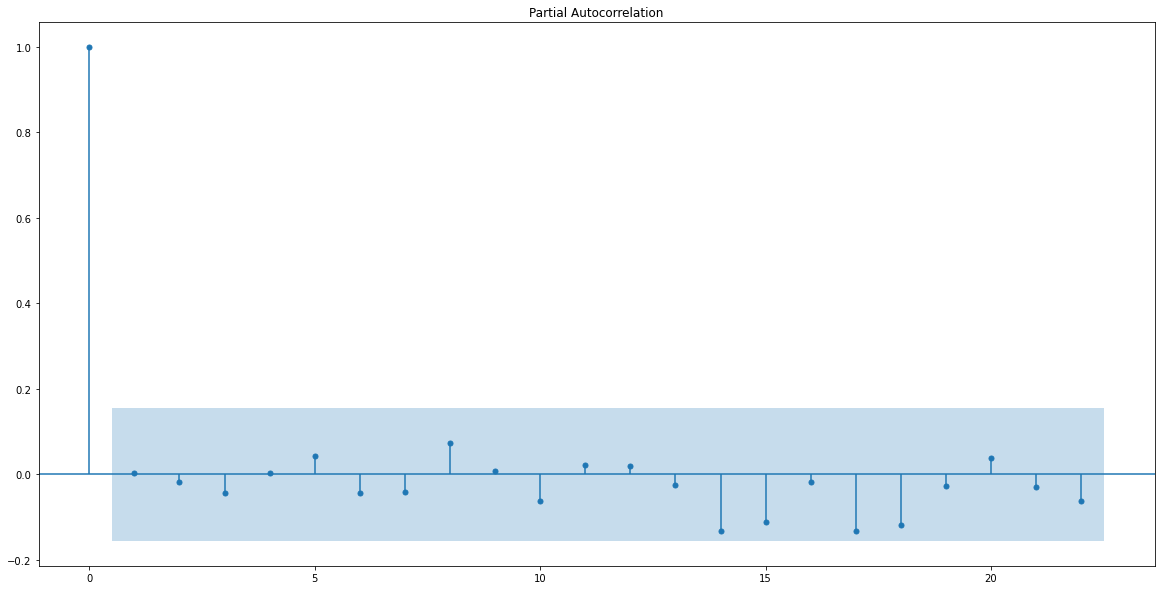

In [25]:
plot_pacf(residuals)
plt.show()

#### The ACF and PACF resisuals are also a sign of the goodness of our fit.

## 4. Forecast (over the test period)

To see how well the model performs, we forecast over the test period and then add the trend and seasonality.
We compare the forecast with test data using the RMSE.

In [26]:
X_test = np.linspace(158,158+len(data_test),num = len(data_test)).reshape(-1,1) #test time steps

prediction = results.predict(158,159+48)
prediction += PolynomialRegression(degree=1).fit(X, data_train).predict(X_test) #add trend
prediction += [seasonality_1[-52-i] for i in range(len(data_test))] #add seasonality

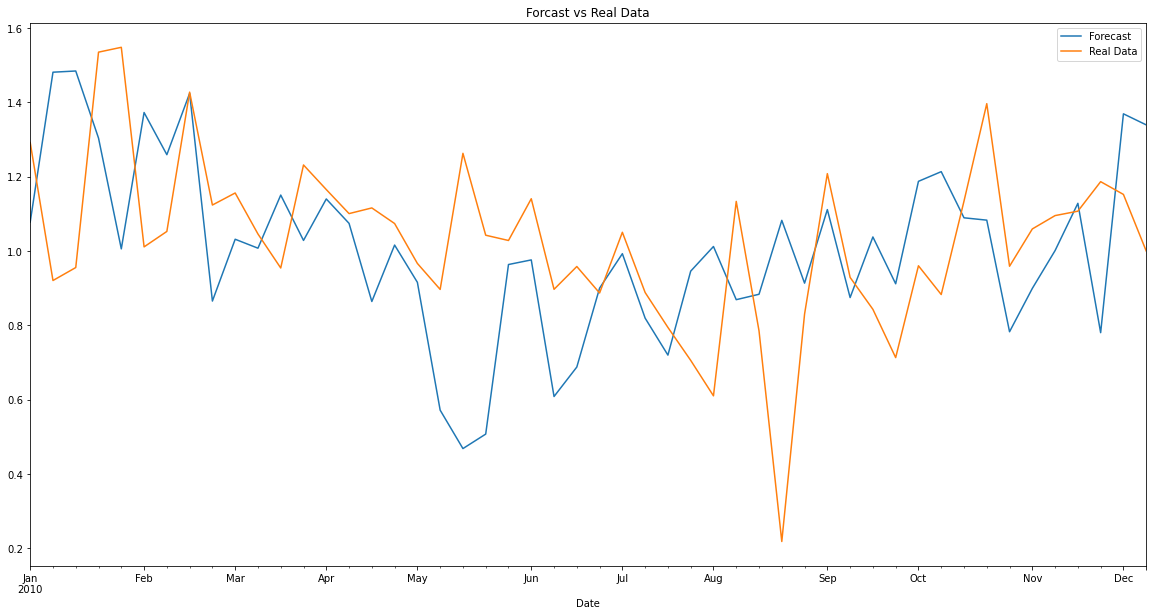

In [27]:
prediction.plot(label='Forecast')
data_test.plot(label='Real Data')
plt.title('Forcast vs Real Data')
plt.legend()

In [28]:
mean_squared_error(data_test.values, prediction)**0.5

0.29715926575730184

To see how well the model performs, we used the root mean squared error, and we had a result of 0.29.

## 5. Volatility Analysis

The ARCH or Autoregressive Conditional Heteroskedasticity method provides a way to model a change in variance in a time series that is time dependent, such as increasing or decreasing volatility. An extension of this approach named GARCH or Generalized Autoregressive Conditional Heteroskedasticity allows the method to support changes in the time dependent volatility, such as increasing and decreasing volatility in the same series.

We're going to fit a GARCH model on our time series using the train data

In [29]:
# define model
model = arch_model(residual_1, mean='Zero', vol='GARCH', p=4, q=4, rescale=False)


# fit model
model_fit = model.fit()

Iteration:      1,   Func. Count:     11,   Neg. LLF: 83137096.65627602
Iteration:      2,   Func. Count:     23,   Neg. LLF: -67.39025481810307
Iteration:      3,   Func. Count:     36,   Neg. LLF: -2.0623614268351957
Iteration:      4,   Func. Count:     48,   Neg. LLF: -70.23208956776435
Iteration:      5,   Func. Count:     60,   Neg. LLF: -72.28820568344841
Iteration:      6,   Func. Count:     70,   Neg. LLF: -69.74569537943758
Iteration:      7,   Func. Count:     81,   Neg. LLF: -72.42577384599274
Iteration:      8,   Func. Count:     91,   Neg. LLF: -72.43367914567581
Iteration:      9,   Func. Count:    101,   Neg. LLF: -72.4341667961029
Iteration:     10,   Func. Count:    111,   Neg. LLF: -72.43418444185804
Iteration:     11,   Func. Count:    121,   Neg. LLF: -72.43419156554482
Iteration:     12,   Func. Count:    130,   Neg. LLF: -72.43419156548491
Optimization terminated successfully    (Exit mode 0)
            Current function value: -72.43419156554482
            Iter

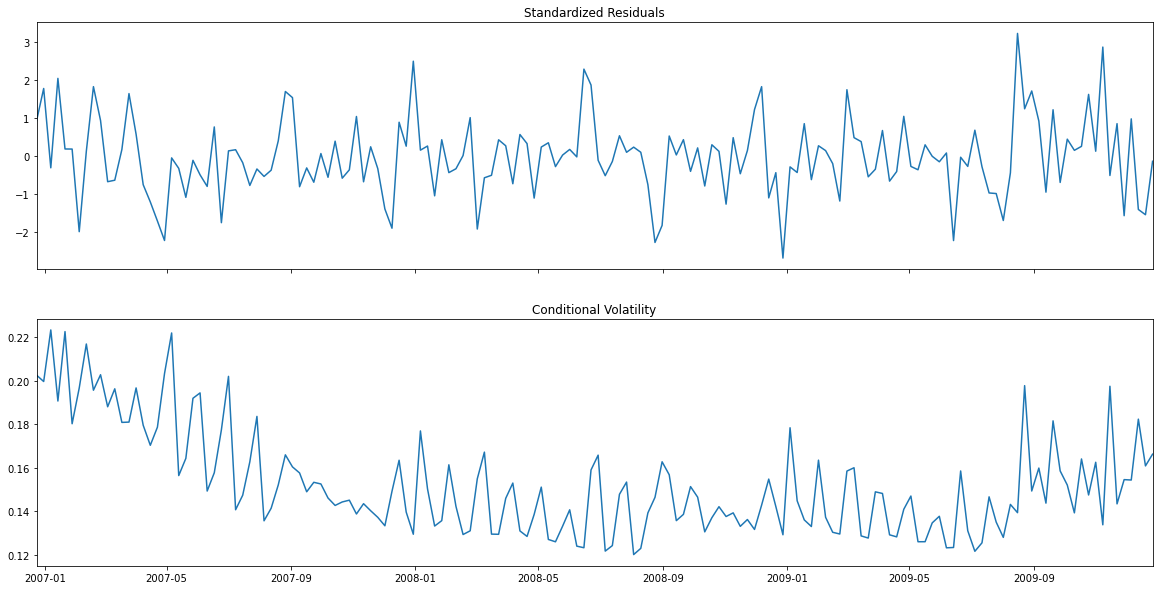

In [30]:
yhat = model_fit.plot()

We then plot the predicted volatility

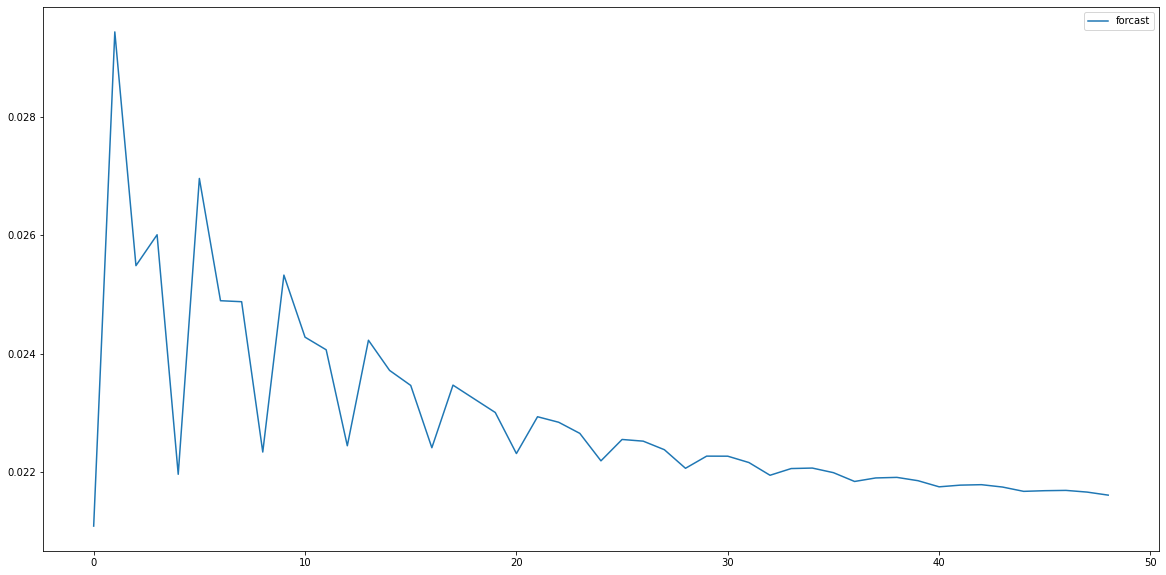

In [31]:
# forecast the test set
yhat = model_fit.forecast(horizon=49)

# plot forecast variance
plt.plot(yhat.variance.values[-1, :],label='forcast')
plt.legend()

plt.show()

We can see that according to the model, the volatily will have a decreasing tendency over test period.